In [1]:

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [2]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [3]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

/Users/jerrydeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [8]:
pca.n_components_

154

### Dimensionality reduction for supervised learning

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [10]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [11]:
X_recovered = pca.inverse_transform(X_reduced)

In [13]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA (batches)

In [15]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [16]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

In [17]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

### Random Projection

In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [21]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T
X_reduced

array([[ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
         1.86509223, -0.62205374],
       [-1.15983875, -1.31973727,  0.13553982, ..., -0.9461484 ,
        -0.01875402,  1.15834454],
       [-2.79258363,  0.47631317, -3.2293912 , ...,  1.41899815,
         3.03817514, -2.07598188],
       ...,
       [ 0.18867284,  0.58379053,  1.42444552, ...,  0.13507484,
         1.83874287, -0.39265772],
       [ 2.54718434,  0.32063561, -3.59830134, ...,  0.49247486,
         0.46798188,  0.09910125],
       [ 3.68422382, -2.65487692,  0.55763148, ...,  2.14734207,
        -1.82840766,  0.76915154]])

In [22]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above
X_reduced

array([[ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
         1.86509223, -0.62205374],
       [-1.15983875, -1.31973727,  0.13553982, ..., -0.9461484 ,
        -0.01875402,  1.15834454],
       [-2.79258363,  0.47631317, -3.2293912 , ...,  1.41899815,
         3.03817514, -2.07598188],
       ...,
       [ 0.18867284,  0.58379053,  1.42444552, ...,  0.13507484,
         1.83874287, -0.39265772],
       [ 2.54718434,  0.32063561, -3.59830134, ...,  0.49247486,
         0.46798188,  0.09910125],
       [ 3.68422382, -2.65487692,  0.55763148, ...,  2.14734207,
        -1.82840766,  0.76915154]])

### Locally linear embeddings (LLE)

In [23]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

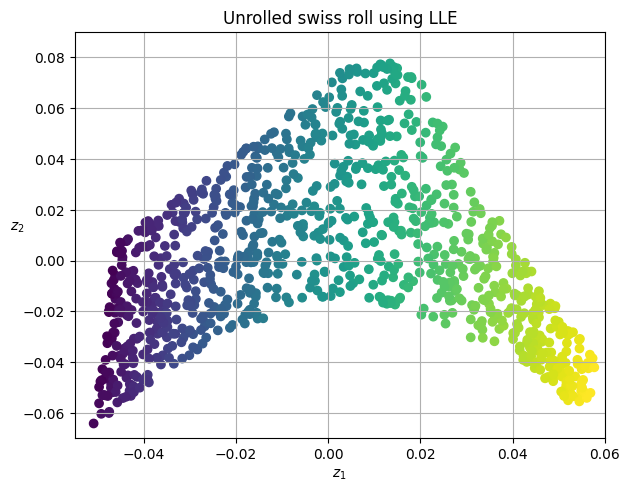

In [29]:
import matplotlib.pyplot as plt
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
# extra code – this cell generates and saves Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()